In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/preprocessed_review.csv")

In [3]:
def label_review(rate):
    if rate >= 4: return 'positive'
    elif rate == 3: return 'neutral'
    else: return 'negative'

df['sentiment'] = df['Puan'].apply(label_review)
df['sentiment'].value_counts()

sentiment
positive    45656
negative    18419
neutral      2219
Name: count, dtype: int64

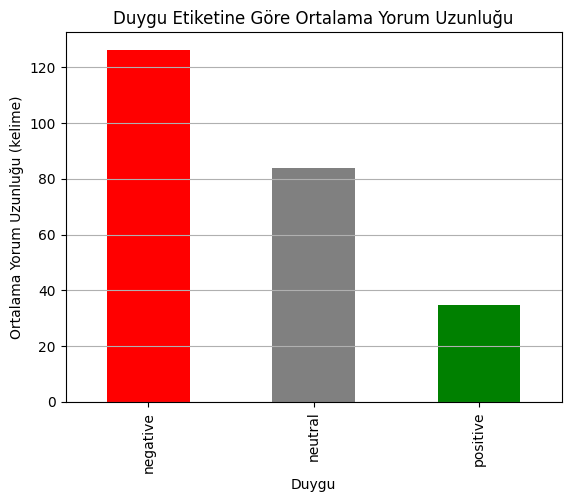

In [4]:

df["review_length"] = df["lemmas"].apply(len)

df.groupby("sentiment")["review_length"].mean().reindex(["negative", "neutral", "positive"]).plot(
    kind="bar", color=["red", "gray", "green"]
)
plt.title("Duygu Etiketine Göre Ortalama Yorum Uzunluğu")
plt.xlabel("Duygu")
plt.ylabel("Ortalama Yorum Uzunluğu (kelime)")
plt.grid(axis='y')
plt.show()



In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "tabularisai/multilingual-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  28%|##7       | 210M/751M [00:00<?, ?B/s]

Device set to use cuda:0


In [19]:
import ast

texts = df["lemmas"].dropna().apply(lambda x: " ".join(ast.literal_eval(x))).tolist()
results = sentiment_pipe(texts, batch_size=128)

In [20]:
df["pred_label"] = [res["label"] for res in results]
df["pred_score"] = [res["score"] for res in results]

In [21]:
def normalize_label(label):
    label = label.lower()
    if "neg" in label:
        return "negative"
    elif "notr" in label or "neutral" in label:
        return "neutral"
    elif "pos" in label:
        return "positive"
    return "unknown"

df["normalized_pred_label"] = df["pred_label"].apply(normalize_label)


In [22]:
from sklearn.metrics import classification_report
print(classification_report(df["sentiment"], df["normalized_pred_label"]))


              precision    recall  f1-score   support

    negative       0.52      0.66      0.58     18419
     neutral       0.06      0.21      0.09      2219
    positive       0.89      0.68      0.77     45656

    accuracy                           0.66     66294
   macro avg       0.49      0.52      0.48     66294
weighted avg       0.76      0.66      0.70     66294



In [30]:
df

,lemmas,Puan,Tarih,sentiment,review_length,pred_label,pred_score,normalized_pred_label
0,"['şua', 'uygula', 'sorun', 'var', 'banka', 'ka...",1,2025-07-07 10:25:20,negative,213,Very Negative,0.392146,negative
1,"['bir', 'türlü', 'dekont', 'al', 'yer', 'öde',...",1,2025-07-07 09:08:45,negative,115,Neutral,0.568174,neutral
2,"['bir', 'uygula', 'bir', 'hafta', 'aç', 'çalış...",1,2025-07-06 22:22:35,negative,212,Neutral,0.300394,neutral
3,"['yabancı', 'ol', 'doğrula', 'yap']",1,2025-07-06 20:02:06,negative,35,Very Negative,0.291021,negative
4,"['şifre', 'güncelle', 'de', 'guncelletmiuorsun...",3,2025-07-06 18:34:42,neutral,58,Very Negative,0.273458,negative
...,...,...,...,...,...,...,...,...
66289,['güzel'],5,2017-08-25 10:43:11,positive,9,Positive,0.535535,positive
66290,"['mobil', 'öde', 'bakiye', 'işlem', 'tarihçe',...",5,2017-08-19 15:08:30,positive,82,Positive,0.397282,positive
66291,['besleme'],4,2017-08-17 06:38:45,positive,11,Neutral,0.320637,neutral
66292,"['fin', 'hit']",5,2017-08-16 20:23:34,positive,14,Positive,0.460450,positive


In [31]:
df[["sentiment","normalized_pred_label"]]

,sentiment,normalized_pred_label
0,negative,negative
1,negative,neutral
2,negative,neutral
3,negative,negative
4,neutral,negative
...,...,...
66289,positive,positive
66290,positive,positive
66291,positive,neutral
66292,positive,positive


In [23]:

df[["lemmas", "normalized_pred_label"]].to_csv("sentiment_results.csv", index=False)


NameError: name 'df_filtered' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
df_filtered = df.loc[df["lemmas"].notna() & df["Puan"].notna()].copy()
df_filtered["pred_star"] = [int(r["score"]) for r in results]

acc = accuracy_score(df_filtered["Puan"], df_filtered["pred_star"])
print(f"Doğruluk: %{acc*100:.2f}")


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_filtered["Puan"], df_filtered["pred_star"]))
